In [1]:
#pip install opencv-python numpy matplotlib seaborn tqdm

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [8]:
# --- Configuration ---
PATH_IMAGES = "/home/vince/ENSTA/4A/projet/scraping/datasets/jeans_troues/troues"
PATH_MASKS = "/home/vince/ENSTA/4A/projet/scraping/datasets/jeans_troues/masks/troues"
HEATMAP_SIZE = (512, 512)  # Taille standard pour la heatmap (vu que les tailles varient)

# Initialisation des conteneurs de données
all_anomaly_counts = []
all_anomaly_sizes = []
anomaly_pixels = []  # Couleurs dans les masques
full_image_pixels = []  # Couleurs globales
heatmap_accumulator = np.zeros(HEATMAP_SIZE, dtype=np.float32)

# Récupération des fichiers (on suppose que les index i correspondent)
mask_files = sorted([f for f in os.listdir(PATH_MASKS)])
count = 0
print(f"{len(mask_files)} images à traiter.")


44 images à traiter.


In [15]:
img_path

'/home/vince/ENSTA/4A/projet/scraping/datasets/jeans_troues/troues/image_1.png'

In [16]:
print("Traitement des images...")


for file_name in tqdm(mask_files):
    # Charger le masque et l'image correspondante
    mask_path = os.path.join(PATH_MASKS, file_name)
    img_path = os.path.join(PATH_IMAGES, file_name).replace(".png",".jpg")
    
    if not os.path.exists(img_path):
        raise ValueError("Il existe un mask qui ne correspond à aucune image.")

    # Lecture (Mask en Noir et Blanc, Image en Couleur RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    # --- 1. Heatmap (Normalisation de la taille) ---
    mask_resized = cv2.resize(mask, HEATMAP_SIZE, interpolation=cv2.INTER_LINEAR)
    heatmap_accumulator += (mask_resized > 0).astype(np.float32)

    # --- 2 & 3. Analyse des Anomalies (Connected Components) ---
    # On définit une anomalie comme un ensemble de pixels blancs contigus
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    # num_labels inclut le fond (label 0), donc on soustrait 1
    num_anomalies = num_labels - 1
    all_anomaly_counts.append(num_anomalies)
    
    # Tailles des anomalies (la colonne 4 de stats est l'aire en pixels)
    if num_anomalies > 0:
        sizes = stats[1:, cv2.CC_STAT_AREA]
        all_anomaly_sizes.extend(sizes)

    # --- 4 & 5. Distribution des Couleurs ---
    # Couleurs dans les anomalies uniquement
    anomaly_mask_bool = mask > 0
    anomaly_pixels.append(image[anomaly_mask_bool])
    
    # Couleurs de l'image complète (on sous-échantillonne pour éviter de saturer la RAM)
    # On prend 1 pixel sur 10 pour la distribution globale
    full_image_pixels.append(image[::10, ::10].reshape(-1, 3))
    
    count += 1

# --- Agrégation des données ---
heatmap_avg = heatmap_accumulator / count
anomaly_pixels = np.vstack(anomaly_pixels)
full_image_pixels = np.vstack(full_image_pixels)

Traitement des images...


100%|██████████| 44/44 [00:00<00:00, 67.09it/s]


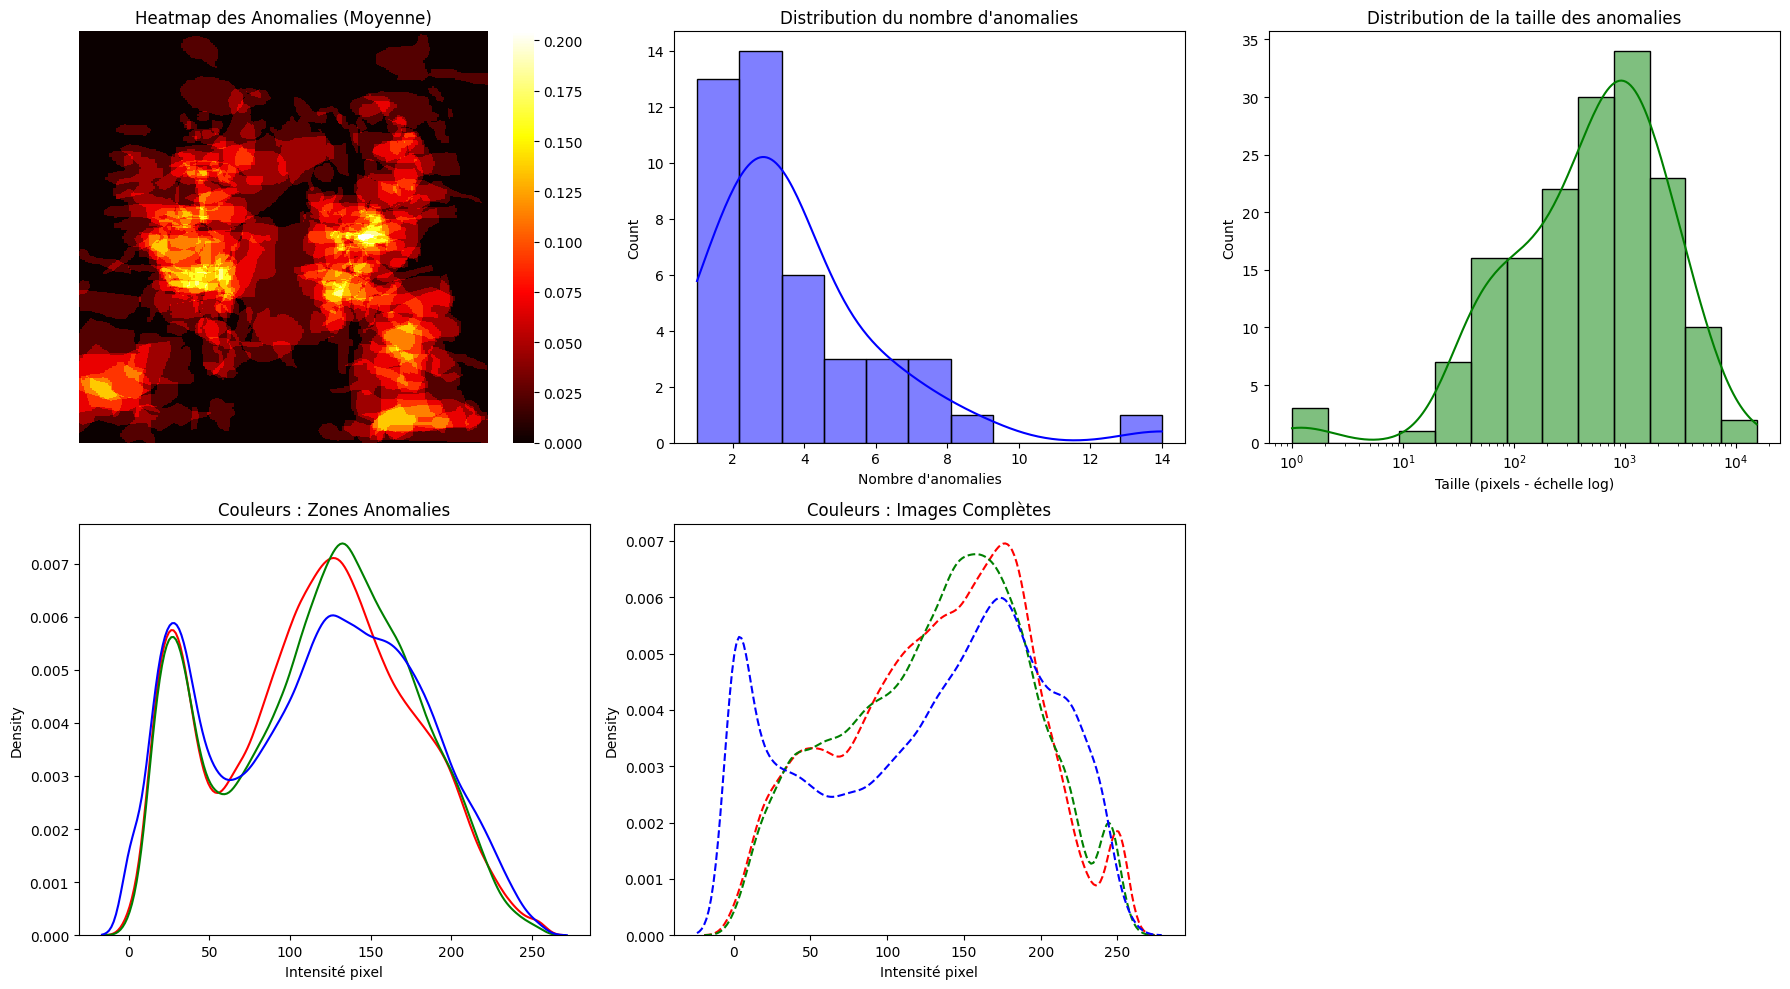

In [17]:
# --- Visualisation ---
plt.figure(figsize=(18, 10))

# Plot 1: Heatmap
plt.subplot(2, 3, 1)
plt.title("Heatmap des Anomalies (Moyenne)")
sns.heatmap(heatmap_avg, cmap='hot', cbar=True, xticklabels=False, yticklabels=False)

# Plot 2: Nb Anomalies par image
plt.subplot(2, 3, 2)
plt.title("Distribution du nombre d'anomalies")
sns.histplot(all_anomaly_counts, kde=True, color='blue')
plt.xlabel("Nombre d'anomalies")

# Plot 3: Taille des anomalies
plt.subplot(2, 3, 3)
plt.title("Distribution de la taille des anomalies")
sns.histplot(all_anomaly_sizes, kde=True, color='green', log_scale=True)
plt.xlabel("Taille (pixels - échelle log)")

# Plot 4: Couleurs (Anomalies)
plt.subplot(2, 3, 4)
plt.title("Couleurs : Zones Anomalies")
for i, color in enumerate(['red', 'green', 'blue']):
    sns.kdeplot(anomaly_pixels[:, i], color=color)
plt.xlabel("Intensité pixel")

# Plot 5: Couleurs (Images Complètes)
plt.subplot(2, 3, 5)
plt.title("Couleurs : Images Complètes")
for i, color in enumerate(['red', 'green', 'blue']):
    sns.kdeplot(full_image_pixels[:, i], color=color, linestyle='--')
plt.xlabel("Intensité pixel")

plt.tight_layout()
plt.show()